In [50]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split, Dataset
from torchvision import models
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from glob import glob
import cv2
import sys
# !pip install timm
import timm
import tqdm
from torchvision import datasets
import random
import math
from PIL import Image                                 #Line 3
import torchvision.transforms.functional as TF        #Line 4
from timm.models.layers import to_2tuple
import pandas as pd
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [ ]:


# torch.cuda.set_device(0)
# print('__Python VERSION:', sys.version)
# print('__pyTorch VERSION:', torch.__version__)
# print('__CUDA VERSION')
# from subprocess import call
# # call(["nvcc", "--version"]) does not work
# ! nvcc --version
# print('__CUDNN VERSION:', torch.backends.cudnn.version())
# print('__Number CUDA Devices:', torch.cuda.device_count())
# print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
# print('Active CUDA Device: GPU', torch.cuda.current_device())
# print ('Available devices ', torch.cuda.device_count())
# print ('Current cuda device ', torch.cuda.current_device())

Define custom dataset

In [54]:
#Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
first_transform = T.Compose([
      T.Resize((224, 224)),
      T.ToTensor(),
  ])


In [6]:
# import torchvision.datasets.ImageFolder
IMG_PATH = '/content/drive/MyDrive/DL-T Cell Segmentatiom/tr_val_test_1donor/'

root_tr = IMG_PATH + 'train/'
root_val = IMG_PATH + 'val/'
root_test = IMG_PATH + 'test/'

In [7]:
class patch_dataset(Dataset):
    def __init__(self, root_dir, transform):

        # self
        self.root_dir = root_dir
        self.path_hc = glob(os.path.join(self.root_dir+ '/0/*.jpg'))
        self.path_lk = glob(os.path.join(self.root_dir+ '/1/*.jpg'))
        self.img_path_list = self.path_hc + self.path_lk
        self.transform = transform
        self.identity = np.array(range(len(self.img_path_list)), dtype=str)

    def __getitem__(self, idx:int):

        img_name = self.img_path_list[idx]
        current_name = img_name.split('/')[-1]
        img = cv2.imread(img_name, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = np.transpose(img, (2, 0, 1))
        
        if self.transform is not None:
          img = self.transform(img)

        if current_name.split('_')[0][0] == 'H':
          label = 0
        else:
          label = 1
        sample = {'image': img, 'label':torch.tensor(label, dtype=torch.int8), 'idx': idx }
        
        return sample 

    def __len__(self):
        return len(self.img_path_list)

In [8]:
train_dataset = torchvision.datasets.ImageFolder(root = root_tr, transform = first_transform)
valid_dataset = torchvision.datasets.ImageFolder(root = root_val, transform = first_transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), num_workers=2)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=len(valid_dataset), num_workers=2)
test_dataset = torchvision.datasets.ImageFolder(root = root_test, transform = first_transform)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), num_workers =2)

In [ ]:
# for i in range(len(trainloader)):

#   data = next(iter(trainloader))
  
#   print((data[0]).shape)

#   R = torch.mean(data[0]), torch.std(data[0])

#   break
# print(R)

In [ ]:
# for i in range(len(validloader)):
#   data = next(iter(validloader))
#   print((data[0]).shape)
#   bb = data[0].mean(), data[0].std()
#   break
# print(bb)

In [ ]:
# for i in range(len(testloader)):
#   data = next(iter(testloader))
#   print((data[0]).shape)
#   bb = data[0].mean(), data[0].std()
#   break
# print(bb)

In [9]:
test_transform = T.Compose([
      T.ToPILImage(), 
#       T.Resize((224, 224)),
      T.ToTensor(),
      T.Normalize(0.0546, 0.1130),

  ])

val_transform = T.Compose([
      T.ToPILImage(),
#       T.RandomHorizontalFlip(),
#       T.RandomVerticalFlip(),  
#       T.Resize((224, 224)),
      T.ToTensor(),
#       T.Normalize(0.05, 0.1224),
      T.Normalize(0.0563, 0.1224),
#     T.Normalize(0.1862, 0.1382),
  ])

train_transform = T.Compose([
    T.ToPILImage(),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),  
#     T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(0.0452, 0.1023),
#     T.Normalize(0.0452, 0.1023),
#     T.Normalize(0.1833, 0.1435),
])

In [10]:
try_dataset = patch_dataset(root_val, val_transform)


(224, 224, 3)
(224, 224, 3)
label tensor(0, dtype=torch.int8)
identity 100


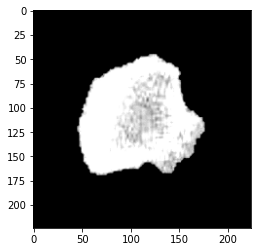

In [11]:
batch = try_dataset.__getitem__(100)
img = batch['image'].numpy()
img = img
img = np.transpose(img, (1,2,0))
print(img.shape)
label = batch['label']
print(img.shape)
plt.imshow(img)
print('label',label)
print('identity', batch['idx'])

In [ ]:
# print(train_filenames[100])

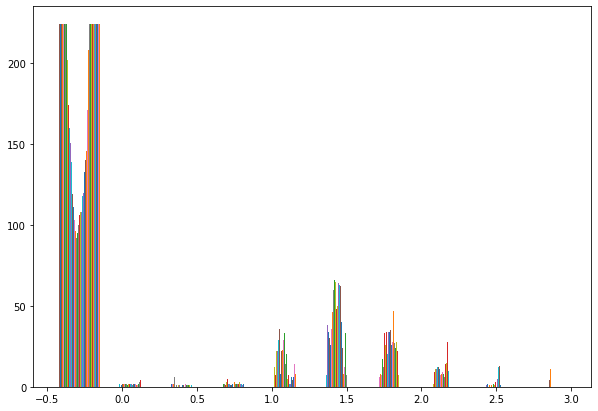

In [ ]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(img[:,:,0])
 
# Show plot
# fig, ax = plt.subplots(figsize =(10, 7))
# ax.hist(img[:,:,1])
plt.show()

In [12]:
def number_of_imgs(path):
  
  class_num = []
  for value in os.listdir(path):
    total_num = 0
    print(value, "has", len(os.listdir(path + value)), "imgs")
    total_num = total_num + len(os.listdir(path + value))
    class_num.append(total_num)
  print('\n')
  return sum(class_num)
    
    

ratio = number_of_imgs(root_tr)

print(ratio)
# print(val_num)

0 has 272 imgs
1 has 300 imgs


572


In [13]:

HUB_URL = "SharanSMenon/swin-transformer-hub:main"
MODEL_NAME = "swin_tiny_patch4_window7_224"
# check hubconf for more models.


In [118]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 1
model = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True) # load from torch hub

# for param in model.parameters(): #freeze model
#     param.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 64),
    nn.ReLU(),
    nn.Dropout(0.5),
#     nn.Linear(256, 128),
#     nn.ReLU(),
#     nn.Dropout(0.5),
    nn.Linear(64, 1),
    nn.Sigmoid()    
)
print(model.head)
model = model.to(device)


Using cache found in /root/.cache/torch/hub/SharanSMenon_swin-transformer-hub_main


Sequential(
  (0): Linear(in_features=768, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=64, out_features=1, bias=True)
  (4): Sigmoid()
)


In [119]:

# criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-6)
# lr scheduler
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.97)
num_epochs = 60

In [120]:
# IMG_PATH = '/media/sail/HDD14T/BME_Grad_Project/Xin and Shiqi/all_dataset/'
IMG_PATH = '/content/drive/MyDrive/DL-T Cell Segmentatiom/tr_val_test_1donor/'
# root_tr = IMG_PATH +'train/'
# root_val = IMG_PATH + 'val/'
root_tr = IMG_PATH +'val/'
root_val = IMG_PATH + 'train/'
root_test = IMG_PATH + 'test/'
bs = 32

train_dataset = patch_dataset(root_dir = root_tr, transform = train_transform)
valid_dataset = patch_dataset(root_dir = root_val, transform = test_transform)
test_dataset = patch_dataset(root_dir = root_test, transform = test_transform)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, num_workers=2, shuffle = True)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=bs, num_workers=2, shuffle = True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, num_workers=2, shuffle = True)

train_filenames = glob(os.path.join(root_tr + '/0/*.jpg')) + glob(os.path.join(root_tr + '/1/*.jpg'))
valid_filenames = glob(os.path.join(root_val + '/0/*.jpg')) + glob(os.path.join(root_val + '/1/*.jpg'))
test_filenames = glob(os.path.join(root_test + '/0/*.jpg')) + glob(os.path.join(root_test + '/1/*.jpg'))


In [121]:


# Define the K-fold Cross Validator
kfold = 1
train_acc = []
train_result = []
valid_acc = []
valid_result = []
bs =bs


patience = 2


def train_net(patience, number_id):
    
    trigger_times = 0
    
    # Start print
    print('--------------------------------')

   
    print('--------------------------------')

#       IMG_PATH = '/media/sail/HDD14T/BME_Grad_Project/Xin and Shiqi/CV' + str(number_id) + '_multiplied/'


    n_train = len(trainloader)
    n_valid = len(validloader)    

    train_accuracy = list()
    train_loss = list()
    valid_loss = list()
    valid_accuracy = list()

    loss_function = nn.BCELoss().to(device)


    # Run the training loop for defined number of epochs
    for epoch in range(0, num_epochs):

        # Print epoch
        print(f'Starting epoch {epoch+1}')
        model.train()
        train_batch_loss = list()
        train_batch_accuracy = list()
        
        # Iterate over the DataLoader for training data
        for i, batch in enumerate(trainloader):
                train_correct = 0
                train_total = 0

                inputs = batch['image'].to(device)
                labels = batch['label'].float().view(inputs.size(0), 1).to(device)

                outputs = model(inputs)

                pred_binary = (outputs > 0.5)

                # Compute loss
                loss = loss_function(outputs, labels)

                train_correct = train_correct + (pred_binary == labels).sum().item()
                train_total = train_total + labels.size(0)

                # Zero the gradients
                optimizer.zero_grad()

                # Perform backward pass
                loss.backward()

                # Perform optimization
                optimizer.step()
                # exp_lr_scheduler.step()

              # Print statistics
                batch_loss = loss.item()
                train_batch_loss.append(batch_loss)
                train_batch_accuracy.append(train_correct/train_total)

        epoch_train_loss = np.array(train_batch_loss).mean()
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = np.array(train_batch_accuracy).mean()
        train_accuracy.append(epoch_train_accuracy)

        model.eval()
        valid_batch_loss = list()
        valid_batch_accuracy = list()
        
        with torch.set_grad_enabled(False):

            # Iterate over the test data and generate predictions
                for i, batch in enumerate(validloader):
                    valid_correct = 0
                    valid_total = 0

                    inputs = batch['image'].to(device)
                    labels = batch['label'].float().view(inputs.size(0),1).to(device)


                    outputs = model(inputs)

                    pred_binary = (outputs > 0.5)

                    loss = loss_function(outputs, labels)
                    # print('loss', loss)
                    valid_correct = valid_correct + (pred_binary == labels).sum().item()
                    valid_total = valid_total + labels.size(0)

                    batch_loss = loss.item()
                    valid_batch_loss.append(batch_loss)

                    valid_batch_accuracy.append(valid_correct/valid_total)



                epoch_valid_loss = np.array(valid_batch_loss).mean()
                valid_loss.append(epoch_valid_loss)
                epoch_valid_accuracy = np.array(valid_batch_accuracy).mean()
                valid_accuracy.append(epoch_valid_accuracy)

        print(f'EPOCH {epoch + 1}/{num_epochs} - Training Loss: {epoch_train_loss} - Training Accuracy: {epoch_train_accuracy} - Validation Loss: {epoch_valid_loss} - Validation Accuracy: {epoch_valid_accuracy}')  
        torch.save(model.state_dict(), f'/content/drive/MyDrive/DL-T Cell Segmentatiom/saved_model/epoch_{epoch+1:03}.pth')
#         if epoch > 3:
#             if valid_accuracy[-1] - valid_accuracy[-2] > 0:
#                 trigger_times += 1
#             print('Trigger Times:', trigger_times)

#         if trigger_times >= patience:
#             print('Early stopping!\nStart to test process.')
#             break


    print('--------------------------------')

    return train_loss, train_accuracy, valid_loss, valid_accuracy, train_filenames, valid_filenames

In [122]:
number_id = 2
avg_train_loss, avg_train_accuracy, avg_valid_loss, avg_valid_accuracy, train_filenames, valid_filenames = train_net(3, number_id)

--------------------------------
--------------------------------
Starting epoch 1
EPOCH 1/60 - Training Loss: 0.7029899587998023 - Training Accuracy: 0.4519230769230769 - Validation Loss: 0.679852137962977 - Validation Accuracy: 0.6297123015873016
Starting epoch 2
EPOCH 2/60 - Training Loss: 0.7021018312527583 - Training Accuracy: 0.49759615384615385 - Validation Loss: 0.6771488553947873 - Validation Accuracy: 0.7152777777777778
Starting epoch 3
EPOCH 3/60 - Training Loss: 0.6855232623907236 - Training Accuracy: 0.5048076923076923 - Validation Loss: 0.6749719778696696 - Validation Accuracy: 0.7566964285714285
Starting epoch 4
EPOCH 4/60 - Training Loss: 0.6939759300305293 - Training Accuracy: 0.5408653846153846 - Validation Loss: 0.6709535916646322 - Validation Accuracy: 0.7869543650793651
Starting epoch 5
EPOCH 5/60 - Training Loss: 0.6920497692548312 - Training Accuracy: 0.46153846153846156 - Validation Loss: 0.6681887143188052 - Validation Accuracy: 0.7943948412698413
Starting epoc

In [ ]:
# number_id = 3
# torch.save(model.state_dict(), f'/media/sail/HDD14T/BME_Grad_Project/Xin and Shiqi/model/tr_val_test_bbox.pth')

59


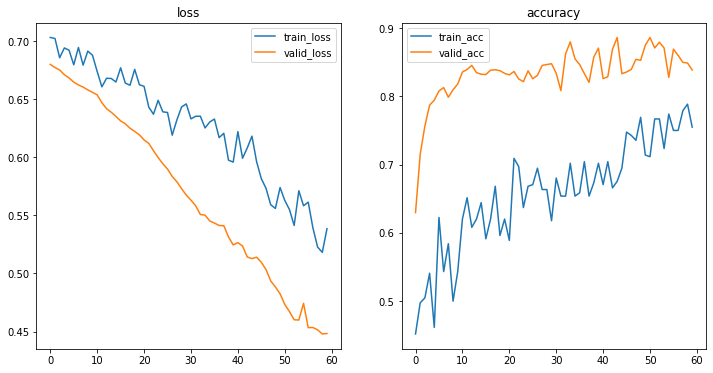

In [123]:
best_epoch = (np.argmin(avg_valid_loss) + 1)
# best_epoch = (np.argmax(avg_valid_accuracy) + 1)
print(best_epoch)
plt.figure(figsize = [12, 6])
plt.subplot(121)
plt.plot(avg_train_loss, label="train_loss")
plt.plot(avg_valid_loss, label="valid_loss")
plt.title('loss')
plt.legend()

plt.subplot(122)
plt.plot(avg_train_accuracy, label="train_acc")
plt.plot(avg_valid_accuracy, label="valid_acc")
plt.title('accuracy')
plt.legend()

In [124]:
# best_epoch = 11
state_dict = torch.load(f'/content/drive/MyDrive/DL-T Cell Segmentatiom/saved_model/epoch_{best_epoch:03}.pth')
# state_dict = torch.load(f'/content/drive/MyDrive/Jan11th/residual_attention_unet/epoch_{best_epoch:03}.pth')

model.load_state_dict(state_dict)
model.cuda()

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      dim=96, input_resolution=(56, 56), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          dim=96, input_resolution=(56, 56), num_heads=3, window_size=7, shift_size=0, mlp_ratio=4.0
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            dim=96, window_size=(7, 7), num_heads=3
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNo

In [125]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
def plot_roc_curve(true_y, y_prob):
      fpr, tpr, thresholds = roc_curve(true_y, y_prob)
      plt.figure()
      plt.plot(fpr, tpr)
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')


In [126]:
import re
def image_accuracy(result, ratio, type):
  # pred = pred.numpy()
  # labels = labels.numpy()
    idx = result[:,2]
#     print(idx[0:10])
#     label = result[:,0]
    pred = result[:,1]
    image_list = list()
#     num_imgs = len(label)

    if type == 'train':
        filenames = train_filenames
    elif type == 'val':
        filenames = valid_filenames
    elif type == 'test':
        filenames = test_filenames

#     print(len(pred))

    for i in (idx):
        i = int(i)
#         print(filenames[0:5])
        curr_identity = filenames[i].split('/')[-1]
#         print(curr_identity)
        image_name = re.sub(curr_identity.split('_')[-1], '', curr_identity)
#         print(image_name)
        image_list.append(image_name)
        

    image_list = np.asarray(image_list)
    num_imgs = len(np.unique(image_list))
    true_label = 0
    pred_label = 0
    image_pred_label = np.zeros((num_imgs))
    image_true_label = np.zeros((num_imgs))
    image_pred_rate = np.zeros((num_imgs))

    
    
    for i in range(num_imgs):
        current_image_name = np.unique(image_list)[i] 
        patch_id = np.where(image_list == current_image_name)
        patch_id = np.array(patch_id)
#         print(patch_id.shape[1])
#         print(pred[patch_id])
#         print('sum',np.sum(pred[patch_id] == 1))
        positive_ratio = np.sum(pred[patch_id] == 1)/patch_id.shape[1]
        image_pred_rate[i] = positive_ratio
#         print(positive_ratio)
        if positive_ratio > ratio:
            pred_label = 1
        else:
            pred_label = 0
        
        print(current_image_name, positive_ratio)
        if current_image_name[0] == 'L':
            true_label = 1
#             print(0)
        else:
            true_label = 0
#         print(true_label)
            
        image_true_label[i] = true_label
        image_pred_label[i] = pred_label
        
    print('img', image_pred_label)
    print('labels', image_true_label)
    print(np.sum(image_pred_label == image_true_label))
    accuracy = np.sum(image_true_label == image_pred_label)/len(np.unique(image_list))
 
    return accuracy, image_pred_label, image_true_label, image_pred_rate

In [127]:
def test_net(net, test_dataloader, ratio, num, data_type ):
    # Create the pred_mask folder
    # if not os.path.isdir('/content/drive/MyDrive/Result_v10'):
    #     os.mkdir('/content/drive/MyDrive/Result_v10')
    
    net.eval()
    
    n_test = len(test_dataloader)
    # test_batch_loss = list()
    # test_batch_dice = list()
    batch_test_accuracy = list()
    # test_batch_CM = list()
    batch_test_loss = list()
    result = np.zeros((num, 4))

    loss_function = nn.BCELoss().to(device)

    # This part is almost the same as the validation loop in `train_net` function. 
    # The difference is that we will calculate the accuracy and confusion matrix per each batch and save the predicted images.
    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):
            
            
            # Load a batch and pass it to the GPU
            test_correct = 0
            imgs = batch['image'].to(device)
            # print('image',imgs.shape)
            # print('labels',batch['label'].shape )
            labels = batch['label'].float().view(imgs.size(0),1).to(device)
            idx = batch['idx'].int().view(imgs.size(0),1).to(device)
 
            y_pred = net(imgs)
            pred_binary = (y_pred > 0.5).to(device)
            # pred_binary = y_pred.cpu().numpy()

            loss = loss_function(y_pred, labels).item()
            batch_test_loss.append(loss)

            test_correct = test_correct + (pred_binary == labels).sum().item()
            test_total = labels.size(0)
            batch_test_accuracy.append(test_correct/test_total)

            batch_result = np.concatenate((labels.cpu().numpy(), pred_binary.cpu().numpy(),idx.cpu().numpy(), y_pred.cpu()), axis=1)
#             print('batch id: ',i)
#             print(batch_result.shape)
            bs_num = bs
#             result.append(batch_result)
#             print((i)*bs_num + bs_num)
            if i == len(test_dataloader)-1:
                result[(i)*bs_num:,:] = batch_result
            else:     
                result[(i)*bs_num:(i)*bs_num + bs_num,:] = batch_result
#             curr_result = np.vstack((curr_result, batch_result))
#         result_np = np.zeros(((len(result)-1)*bs_num + len(result[-1]),4))    
#         for i in len(result):
#             result_np[
#         result = np.array(result)
#         print(curr_result.shape)

        test_loss = np.array(batch_test_loss).mean()
        test_accuracy = np.array(batch_test_accuracy).mean()

        
        dir_type = data_type
        test_img_accuracy, img_pred, img_true, img_pred_rate = image_accuracy(result, ratio, dir_type)
        
#         img_result = np.concatenate((img_pred, img_true, img_pred_rate), axis = 1)

        print(f'Test Loss: {test_loss} - Patch Level Accuracy: {test_accuracy} - Image Level Accuracy: {test_img_accuracy}')  

        


        

            

            
    
    return result, img_pred, img_true, img_pred_rate

In [ ]:
# state_dict = torch.load(f'/media/sail/HDD14T/BME_Grad_Project/Xin and Shiqi/model/fold_{2}.pth')
# state_dict = torch.load(f'/media/sail/HDD14T/BME_Grad_Project/Xin and Shiqi/model/tr_val_test_bbox.pth')
# model.load_state_dict(state_dict)
# model.cuda()

In [128]:
number_id = 2
# # bs = 256
# IMG_PATH = '/media/sail/HDD14T/BME_Grad_Project/Xin and Shiqi/CV' + str(number_id) + '_multiplied/'
# root_val = IMG_PATH + 'test/'
test_dataset = patch_dataset(root_dir = root_test, transform = test_transform)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, num_workers=0, shuffle=True)

# testloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, num_workers=0)

In [129]:
num_imgs = number_of_imgs(root_test)
print(num_imgs)

1 has 100 imgs
0 has 86 imgs


186


In [130]:
pat_result_test, img_pred_test, img_true_test, img_pred_rate_test = test_net(model, testloader, ratio = 0.5, num=number_of_imgs(root_test), data_type = 'test')

1 has 100 imgs
0 has 86 imgs


H1_20210225_10to1_40min_2_01_ 0.5
H1_20210225_10to1_40min_2_03_ 0.5
H1_20210225_10to1_40min_2_04_ 0.6666666666666666
H1_20210225_10to1_40min_2_05_ 0.36363636363636365
LK2_20210305_10to1_40min_2_01_ 0.9583333333333334
LK2_20210305_10to1_40min_2_02_ 0.9090909090909091
LK2_20210305_10to1_40min_2_03_ 0.8125
LK2_20210305_10to1_40min_2_04_ 0.9411764705882353
LK2_20210305_10to1_40min_2_09_ 0.9047619047619048
img [0. 0. 1. 0. 1. 1. 1. 1. 1.]
labels [0. 0. 0. 0. 1. 1. 1. 1. 1.]
8
Test Loss: 0.5426657249530157 - Patch Level Accuracy: 0.735176282051282 - Image Level Accuracy: 0.8888888888888888


In [131]:
val_dataset = patch_dataset(root_dir = root_val, transform = test_transform)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=bs, num_workers=0)

In [99]:
print(bs)

32


In [132]:
num_imgs = number_of_imgs(root_val)
print(num_imgs)
# print(len(trloader))

0 has 272 imgs
1 has 300 imgs


572


In [133]:
pat_result_val, img_pred_val, img_true_val, img_pred_rate_val = test_net(model, valloader, ratio = 0.5, num=number_of_imgs(root_val),  data_type = 'val')

0 has 272 imgs
1 has 300 imgs


H3_20210917_10to1_40min_2_01_ 0.0
H3_20210917_10to1_40min_2_02_ 0.0
H3_20210917_10to1_40min_2_04_ 0.125
H3_20210917_10to1_40min_2_06_ 0.05555555555555555
H3_20210917_10to1_40min_2_07_ 0.043478260869565216
H3_20210917_10to1_40min_2_10_ 0.038461538461538464
H3_20210923_10to1_40min_2_01_ 0.0
H3_20210923_10to1_40min_2_03_ 0.0
H3_20210923_10to1_40min_2_04_ 0.0
H3_20210923_10to1_40min_2_05_ 0.0
H3_20210923_10to1_40min_2_10_ 0.034482758620689655
H3_20210924_10to1_40min_2_05_ 0.0
H3_20210924_10to1_40min_2_09_ 0.08333333333333333
H3_20210924_10to1_40min_2_10_ 0.0
LK18_20210305_10to1_40min_2_01_ 0.7428571428571429
LK18_20210305_10to1_40min_2_02_ 0.6
LK18_20210305_10to1_40min_2_03_ 0.8148148148148148
LK18_20210305_10to1_40min_2_04_ 0.8260869565217391
LK18_20210305_10to1_40min_2_05_ 0.8260869565217391
LK18_20210305_10to1_40min_2_06_ 0.7317073170731707
LK18_20210305_10to1_40min_2_07_ 0.7837837837837838
LK18_20210305_10to1_40min_2_08_ 0.7142857142857143
LK18_20210305_

In [134]:
tr_dataset = patch_dataset(root_dir = root_tr, transform = test_transform)
trloader = torch.utils.data.DataLoader(tr_dataset, batch_size=bs, num_workers=0)

In [135]:
pat_result_tr, img_pred_tr, img_true_tr, img_pred_rate_tr = test_net(model, trloader, ratio = 0.5, num=number_of_imgs(root_tr),  data_type = 'train')

1 has 186 imgs
0 has 200 imgs


H1_20210225_10to1_40min_2_01_ 0.2857142857142857
H1_20210225_10to1_40min_2_02_ 1.0
H1_20210225_10to1_40min_2_03_ 0.25
H1_20210225_10to1_40min_2_04_ 0.45454545454545453
H1_20210225_10to1_40min_2_05_ 0.29411764705882354
H1_20210225_3to1_40min_2_01_ 0.3
H1_20210225_3to1_40min_2_02_ 0.26666666666666666
H1_20210225_3to1_40min_2_04_ 0.25
H2_20210401_10to1_40min_2_01_ 0.0
H2_20210401_10to1_40min_2_03_ 0.11538461538461539
H2_20210826_10to1_40min_2_03_ 0.5454545454545454
H2_20210827_10to1_40min_2_02_ 0.0
LK51_20210319_10to1_40min_2_01_ 0.9354838709677419
LK51_20210319_10to1_40min_2_02_ 0.7083333333333334
LK51_20210319_10to1_40min_2_03_ 0.875
LK51_20210319_10to1_40min_2_04_ 0.8823529411764706
LK51_20210319_10to1_40min_2_05_ 0.7142857142857143
LK51_20210319_10to1_40min_2_07_ 0.8636363636363636
LK51_20210319_10to1_40min_2_08_ 0.8666666666666667
LK51_20210319_10to1_40min_2_09_ 0.7857142857142857
LK51_20210319_10to1_40min_2_10_ 0.8823529411764706
img [0. 1. 0. 0. 0. 0

In [43]:
pat_pred_tr = pat_result_tr[:,3]
pat_true_tr = pat_result_tr[:,0]
print(pat_pred_tr.shape)

(386,)


In [104]:
pat_pred_val = pat_result_val[:,3]
pat_true_val = pat_result_val[:,0]
print(pat_pred_val.shape)

(572,)


In [105]:
pat_pred_test = pat_result_test[:,3]
pat_true_test = pat_result_test[:,0]
print(pat_pred_test.shape)

(186,)


In [136]:
def ROCanalysis(pred, true):
    
    fpr, tpr, thresholds = roc_curve(true, pred)
#     print(fpr[:10],tpr[:10],thresholds[:10])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label="AUC="+str(roc_auc_score(true, pred)))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    print("Area under the ROC cuve : %f" % roc_auc)
          
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'tf' :pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(thresholds, index = i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
#     print(roc_t)
#     print(roc_t['threshold'])
    
    print("Optimal cutoff point is : %f" % roc_t['threshold'])
    
          

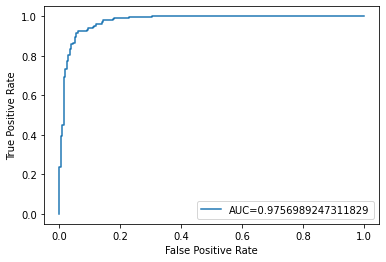

Area under the ROC cuve : 0.975699
Optimal cutoff point is : 0.988224


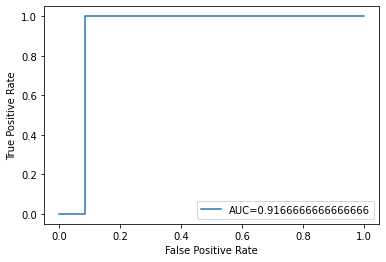

Area under the ROC cuve : 0.916667
Optimal cutoff point is : 0.708333


In [137]:
ROCanalysis(pat_pred_tr, pat_true_tr)
ROCanalysis(img_pred_rate_tr, img_true_tr)

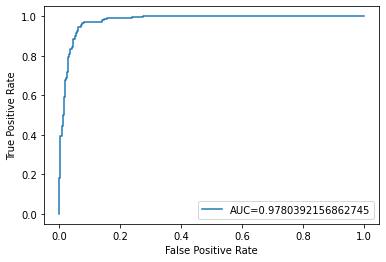

Area under the ROC cuve : 0.978039
Optimal cutoff point is : 0.216361


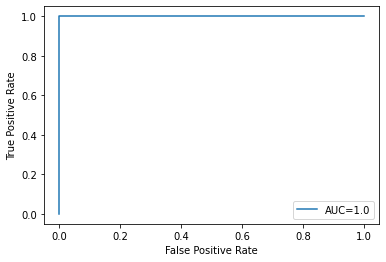

Area under the ROC cuve : 1.000000
Optimal cutoff point is : 0.575758


In [138]:
ROCanalysis(pat_pred_val, pat_true_val)
ROCanalysis(img_pred_rate_val, img_true_val)

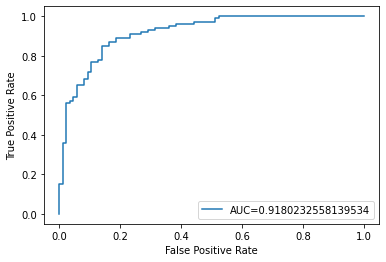

Area under the ROC cuve : 0.918023
Optimal cutoff point is : 0.931776


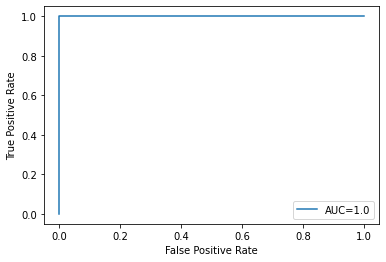

Area under the ROC cuve : 1.000000
Optimal cutoff point is : 0.812500


In [139]:
ROCanalysis(pat_pred_test, pat_true_test)
ROCanalysis(img_pred_rate_test, img_true_test)